# Analysis using various Boundary Condition scenarios

In [1]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

# 모델 라이브러리
# from src.model.cmaqnet_cond_unet import build_model

# 학습 및 처리/분석 관련 라이브러리
import numpy as np
import pandas as pd
import netCDF4 as nc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Geometric 및 시각화 라이브러리
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import joblib
scaler = StandardScaler()
scaler = joblib.load('/home/user/workdir/CMAQ_Emulator/main/o3_training/o3_prediction_origin_boundary.pkl')
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

2025-03-24 16:53:58.848865: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 16:53:58.879044: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-24 16:53:58.879076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 16:53:58.879090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 16:53:58.884844: I tensorflow/core/platform/cpu_feature_g

In [4]:
test_split = 0.2  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/final_model_boundary')

# 입력 데이터셋 로드
emis_ctrl_2019_05 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_o3.csv', index_col=0)
emis_ctrl_2019_05['Boundary'] = 0.5
''' 0.6, 0.7, 0.75, 0.8, 0.85 condition 추가'''
emis_ctrl_2019_06 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_06['Boundary'] = 0.6
emis_ctrl_2019_07 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_07['Boundary'] = 0.7
emis_ctrl_2019_075 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_075['Boundary'] = 0.75
emis_ctrl_2019_08= emis_ctrl_2019_05.copy()
emis_ctrl_2019_08['Boundary'] = 0.8
emis_ctrl_2019_085= emis_ctrl_2019_05.copy()
emis_ctrl_2019_085['Boundary'] = 0.85
emis_ctrl_2019_10 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_10['Boundary'] = 1.0
ctrl_data = pd.concat([
    emis_ctrl_2019_05,
    emis_ctrl_2019_06,
    emis_ctrl_2019_07,
    emis_ctrl_2019_075,
    emis_ctrl_2019_08,
    emis_ctrl_2019_085,
    emis_ctrl_2019_10
], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*2], ctrl_data[:, 17*2]  # 17*2개의 입력 변수와 마지막 열(Boundary)

_, X_emis_test, _, X_boundary_test = train_test_split(
    pred_emis_data, 
    pred_boundary_data, 
    test_size=test_split, 
    random_state=random_seed, 
    stratify=pred_boundary_data
)
y_preds_scaled = model.predict([X_emis_test,  X_boundary_test])
n_samples = y_preds_scaled.shape[0]  # 테스트 샘플 수
y_preds = scaler.inverse_transform(y_preds_scaled.reshape(n_samples, -1))
y_preds = y_preds.reshape(y_preds_scaled.shape)
y_pred = y_preds.squeeze()

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
6/6 [==============================] - 3s 22ms/step


### Scenario analysis according to boundary 

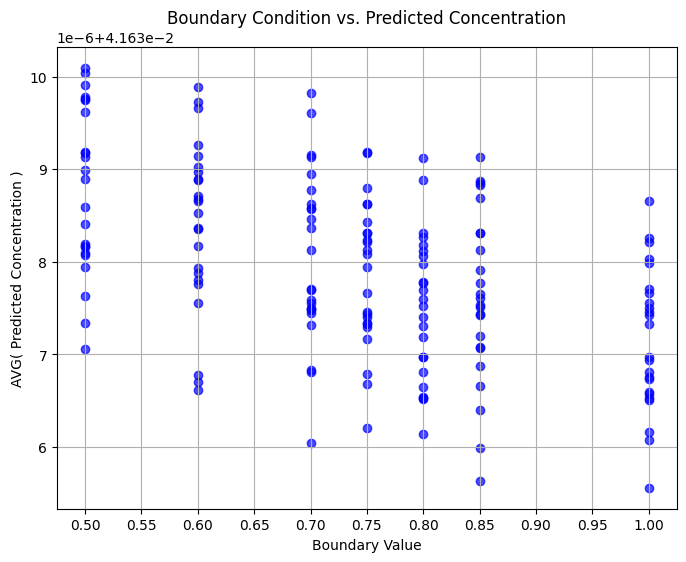

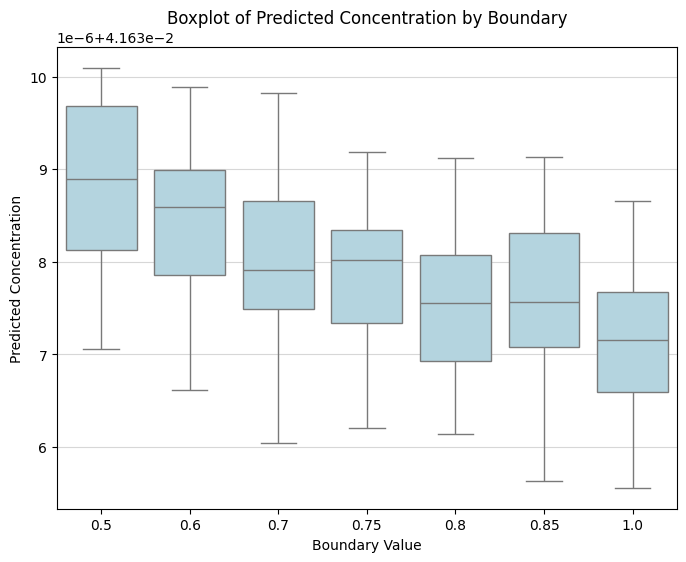

   boundary  mean_val       std_val   min_val   max_val  count
0      0.50  0.041639  9.048317e-07  0.041637  0.041640     23
1      0.60  0.041638  9.105473e-07  0.041637  0.041640     24
2      0.70  0.041638  9.334353e-07  0.041636  0.041640     24
3      0.75  0.041638  7.769227e-07  0.041636  0.041639     24
4      0.80  0.041638  7.791073e-07  0.041636  0.041639     24
5      0.85  0.041638  9.275162e-07  0.041636  0.041639     24
6      1.00  0.041637  7.735869e-07  0.041636  0.041639     24


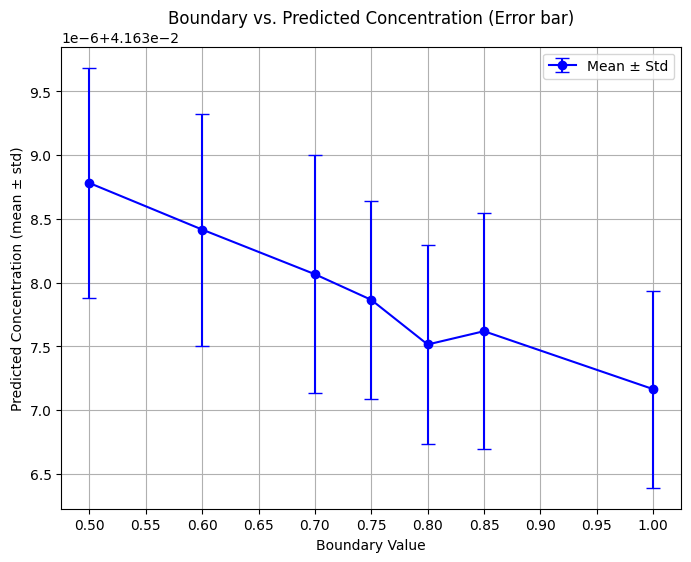

In [5]:
import seaborn as sns

boundary_vals = X_boundary_test.squeeze()  # shape: (n_samples,)
predicted_means = np.mean(y_pred, axis=(1,2))  # (n_samples,)

# [1] Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(boundary_vals, predicted_means, alpha=0.7, color='blue')
plt.xlabel("Boundary Value")
plt.ylabel("AVG( Predicted Concentration )")
plt.title("Boundary Condition vs. Predicted Concentration")
plt.grid(True)
xmin = np.min(boundary_vals)
xmax = np.max(boundary_vals)
plt.xticks(np.arange(xmin, xmax + 0.05, 0.05))
plt.show()

# [2] Box Plot
df = pd.DataFrame({
    'boundary': boundary_vals,
    'pred_mean': predicted_means
})
plt.figure(figsize=(8,6))
sns.boxplot(x='boundary', y='pred_mean', data=df, color='lightblue')
# sns.violinplot(x='boundary', y='pred_mean', data=df, color='lightgreen')  # 바이올린 플롯 예시
plt.xlabel("Boundary Value")
plt.ylabel("Predicted Concentration")
plt.title("Boxplot of Predicted Concentration by Boundary")
plt.grid(axis='y', alpha=0.5)
plt.show()

# [3] Error-bar Plot
group_stats = df.groupby('boundary')['pred_mean'].agg(
    mean_val='mean',
    std_val='std',
    min_val='min',
    max_val='max',
    count='count'
).reset_index()
print(group_stats)
plt.figure(figsize=(8,6))
plt.errorbar(
    group_stats['boundary'],
    group_stats['mean_val'],
    yerr=group_stats['std_val'],
    fmt='o-', capsize=5, color='blue',
    label='Mean ± Std'
)
plt.xlabel("Boundary Value")
plt.ylabel("Predicted Concentration (mean ± std)")
plt.title("Boundary vs. Predicted Concentration (Error bar)")
plt.grid(True)
# xmin = group_stats['boundary'].min()
# xmax = group_stats['boundary'].max()
plt.xticks(np.arange(xmin, xmax + 0.05, 0.05))
plt.legend()
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 모델 로드
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/final_model_v2')

# 입력 데이터셋 로드 및 생성
emis_ctrl_2019_05 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_pm25.csv')
emis_ctrl_2019_05['Boundary'] = 0.5

# 다양한 boundary condition에 대한 데이터 생성
boundary_conditions = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
data_frames = []

for bc in boundary_conditions:
    df = emis_ctrl_2019_05.copy()
    df['Boundary'] = bc
    data_frames.append(df)

# 모든 데이터프레임 결합
ctrl_data = pd.concat(data_frames, axis=0).reset_index(drop=True).values

# 입력 데이터 분리
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*4], ctrl_data[:, 17*4]

# 테스트 데이터 분할
test_split = 0.2
random_seed = 42
_, X_emis_test, _, X_boundary_test = train_test_split(
    pred_emis_data, 
    pred_boundary_data, 
    test_size=test_split, 
    random_state=random_seed, 
    stratify=pred_boundary_data
)

# 모델 예측 수행
y_preds = model.predict([X_emis_test, X_boundary_test])
print("예측 결과 형태:", y_preds.shape)

# 예측 결과의 평균값 계산 (82x67 영역에 대해)
y_pred_mean = np.mean(y_preds, axis=(1, 2)).flatten()

# 시각화
plt.figure(figsize=(12, 8))

# 각 boundary condition별로 scatter plot 생성
for bc in boundary_conditions:
    mask = X_boundary_test == bc
    if mask.any():
        plt.scatter(X_boundary_test[mask], 
                   y_pred_mean[mask],
                   label=f'BC {bc}',
                   alpha=0.6)

plt.xlabel('Boundary Condition')
plt.ylabel('Average Prediction')
plt.title('Prediction according to Boundary Condition')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# x축 눈금 설정
plt.xticks(boundary_conditions)

# 그래프 저장
plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300, bbox_inches='tight')
plt.close()
'''
# 통계 분석 결과 출력
print("\n=== 통계 분석 ===")
for bc in boundary_conditions:
    mask = X_boundary_test == bc
    if mask.any():
        mean_val = y_pred[mask].mean()
        std_val = y_pred[mask].std()
        print(f"BC {bc}: 평균 = {mean_val:.4f}, 표준편차 = {std_val:.4f}")
'''

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


9/9 [==============================] - 3s 24ms/step
예측 결과 형태: (262, 82, 67, 1)


'\n# 통계 분석 결과 출력\nprint("\n=== 통계 분석 ===")\nfor bc in boundary_conditions:\n    mask = X_boundary_test == bc\n    if mask.any():\n        mean_val = y_pred[mask].mean()\n        std_val = y_pred[mask].std()\n        print(f"BC {bc}: 평균 = {mean_val:.4f}, 표준편차 = {std_val:.4f}")\n'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from numpy.random import RandomState

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU 메모리 성장 활성화 완료")
    except RuntimeError as e:
        print(e)

# 모델 로드
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/final_model_v2')

# 입력 데이터셋 로드
emis_ctrl_2019 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_pm25.csv')

# 랜덤 시드 설정
random_seed = 42
random_state = RandomState(random_seed)

# 랜덤하게 n개의 시나리오 선택
n_scenarios = 10  # 선택할 시나리오 개수
total_scenarios = len(emis_ctrl_2019)
selected_indices = random_state.choice(total_scenarios, size=n_scenarios, replace=False)
selected_emis_ctrl = emis_ctrl_2019.iloc[selected_indices]

print(f"\n선택된 시나리오 인덱스: {selected_indices}")

# boundary condition 값들
boundary_conditions = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

# 각 시나리오별 예측값을 저장할 딕셔너리
predictions_by_scenario = {}

# 선택된 시나리오에 대해서만 예측 수행
for idx, row in selected_emis_ctrl.iterrows():
    scenario_predictions = []
    emis_data = row.values[:17*4].reshape(1, -1)  # 한 시나리오의 배출량 데이터
    
    for bc in boundary_conditions:
        boundary_data = np.array([bc])  # 현재 boundary condition
        
        # 예측 수행
        pred = model.predict([emis_data, boundary_data], verbose=0)
        mean_pred = np.mean(pred, axis=(1, 2)).flatten()[0]  # 82x67 영역의 평균
        scenario_predictions.append(mean_pred)
    
    predictions_by_scenario[idx] = scenario_predictions

# 시각화
plt.figure(figsize=(12, 8))

# 색상과 마커 설정
colors = plt.cm.tab20(np.linspace(0, 1, n_scenarios))  # n_scenarios 만큼의 색상 생성
markers = ['o', 's', '^', 'D', 'v', 'p', 'h', '8', '*', 'H']  # 10개의 마커

for (scenario_idx, predictions), color, marker in zip(predictions_by_scenario.items(), colors, markers):
    for bc, pred in zip(boundary_conditions, predictions):
        plt.scatter(bc, pred, marker=marker, c=[color], s=100, alpha=0.6, 
                   label=f'Scenario {scenario_idx}' if bc == 0.5 else "")
        
    # 각 시나리오의 점들을 선으로 연결 (투명도를 높여서 연결선을 흐리게 표시)
    plt.plot(boundary_conditions, predictions, '-', c=color, alpha=0.2)

plt.xlabel('Boundary Condition')
plt.ylabel('Average Prediction')
plt.title(f'Prediction Tracking for {n_scenarios} Random Scenarios')
plt.grid(True, alpha=0.3)
plt.xticks(boundary_conditions)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 저장
plt.tight_layout()
plt.savefig('scenario_tracking_random.png', dpi=300, bbox_inches='tight')
plt.close()
'''
# 선택된 시나리오의 예측값 변화 출력
print("\n=== 선택된 시나리오의 예측값 변화 ===")
for scenario_idx in predictions_by_scenario.keys():
    print(f"\n시나리오 {scenario_idx}:")
    for bc, pred in zip(boundary_conditions, predictions_by_scenario[scenario_idx]):
        print(f"BC {bc}: {pred:.4f}")
'''

GPU 메모리 성장 활성화 완료
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

선택된 시나리오 인덱스: [ 56  89   4  45  26 117  69  10  90  73]


'\n# 선택된 시나리오의 예측값 변화 출력\nprint("\n=== 선택된 시나리오의 예측값 변화 ===")\nfor scenario_idx in predictions_by_scenario.keys():\n    print(f"\n시나리오 {scenario_idx}:")\n    for bc, pred in zip(boundary_conditions, predictions_by_scenario[scenario_idx]):\n        print(f"BC {bc}: {pred:.4f}")\n'

### 추가 분석

In [6]:
# 시나리오를 1개 추출하여 BC=0.5일때와 BC=1일때에 대한 모델 예측값을 토대로
# BC=0.5일때의 그리드셀 (10, 20)과 BC=1일때의 그리드셀 (10, 20)일때를 ratio로 구하여
# BC 2개 각각의 전체 그리드 셀에 대해 Ratio Map을 형성
# Ratio = (BC_{0.5} / BC_{1.0})

# 만약 위 내용이 진행이 될 경우, 또다른 시나리오를 추출하여 Ratio Map을 만들고
# Ratio Map 간 그리드셀의 Ratio 차이가 어떤 지 확인

1/1 [==============================] - 0s 65ms/step


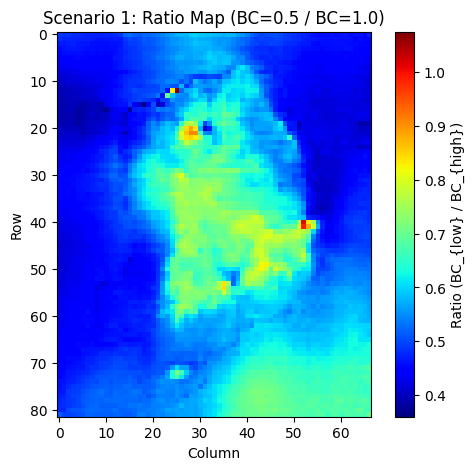

1/1 [==============================] - 0s 62ms/step


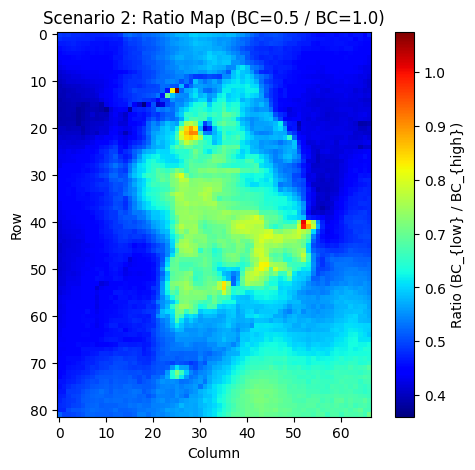

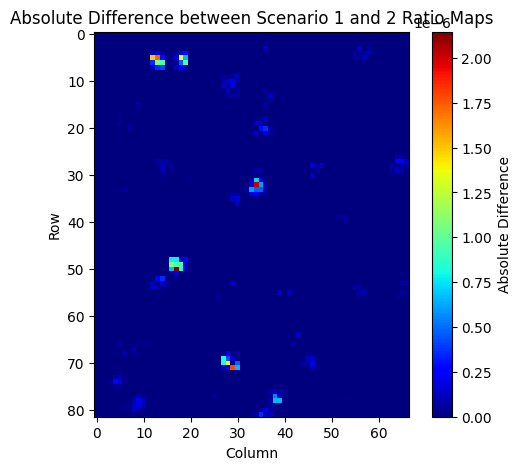

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. 시나리오별 예측값 및 Ratio Map 계산 함수 --- #
def get_prediction_for_boundary(model, control_input, boundary_value):
    """
    model: 학습된 모델 (두 입력을 받음)
    control_input: 1차원 벡터, shape=(ctrl_dim,)
    boundary_value: scalar, 예: 0.5 또는 1.0
    Returns:
        pred_map: 예측 결과, shape=(82,67,1)
    """
    boundary_input = np.array([boundary_value], dtype=np.float32)  # shape (1,)
    # 배치 차원 추가
    control_batch = np.expand_dims(control_input, axis=0)   # shape (1, ctrl_dim)
    boundary_batch = np.expand_dims(boundary_input, axis=0)   # shape (1, 1)
    pred = model.predict([control_batch, boundary_batch])
    return pred[0]  # (82,67,1)

def compute_ratio_map(pred_map_low, pred_map_high):
    """
    pred_map_low: 예측값 for 낮은 boundary (예: 0.5), shape=(82,67,1)
    pred_map_high: 예측값 for 높은 boundary (예: 1.0), shape=(82,67,1)
    Returns:
        ratio_map: elementwise ratio, shape=(82,67) (채널 차원 squeeze)
    """
    # 두 예측 맵을 elementwise 나눔
    ratio_map = pred_map_low / pred_map_high
    # 마지막 채널 축 제거 (shape: (82,67))
    return np.squeeze(ratio_map, axis=-1)

def plot_ratio_map(ratio_map, title="Ratio Map", cmap="jet"):
    plt.figure(figsize=(6,5))
    plt.imshow(ratio_map[::-1], cmap=cmap)
    plt.colorbar(label="Ratio (BC_{low} / BC_{high})")
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()

# --- 2. 하나의 시나리오에서 Ratio Map 계산 --- #
model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/final_model_v2')

base_control = X_emis_test[3]  # 예: shape=(ctrl_dim,)
pred_map_0_5 = get_prediction_for_boundary(model, base_control, boundary_value=0.5)
pred_map_1_0 = get_prediction_for_boundary(model, base_control, boundary_value=1.0)
ratio_map1 = compute_ratio_map(pred_map_0_5, pred_map_1_0)
plot_ratio_map(ratio_map1, title="Scenario 1: Ratio Map (BC=0.5 / BC=1.0)")

# --- 3. 또 다른 시나리오에서 Ratio Map 계산 --- #
base_control2 = X_emis_test[6]
pred_map2_0_5 = get_prediction_for_boundary(model, base_control2, boundary_value=0.5)
pred_map2_1_0 = get_prediction_for_boundary(model, base_control2, boundary_value=1.0)
ratio_map2 = compute_ratio_map(pred_map2_0_5, pred_map2_1_0)
plot_ratio_map(ratio_map2, title="Scenario 2: Ratio Map (BC=0.5 / BC=1.0)")

# --- 4. 두 Ratio Map 간 차이 분석 --- #
ratio_diff = np.abs(ratio_map1 - ratio_map2)
plt.figure(figsize=(6,5))
plt.imshow(ratio_diff, cmap="jet")
plt.colorbar(label="Absolute Difference")
plt.title("Absolute Difference between Scenario 1 and 2 Ratio Maps")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 62ms/step


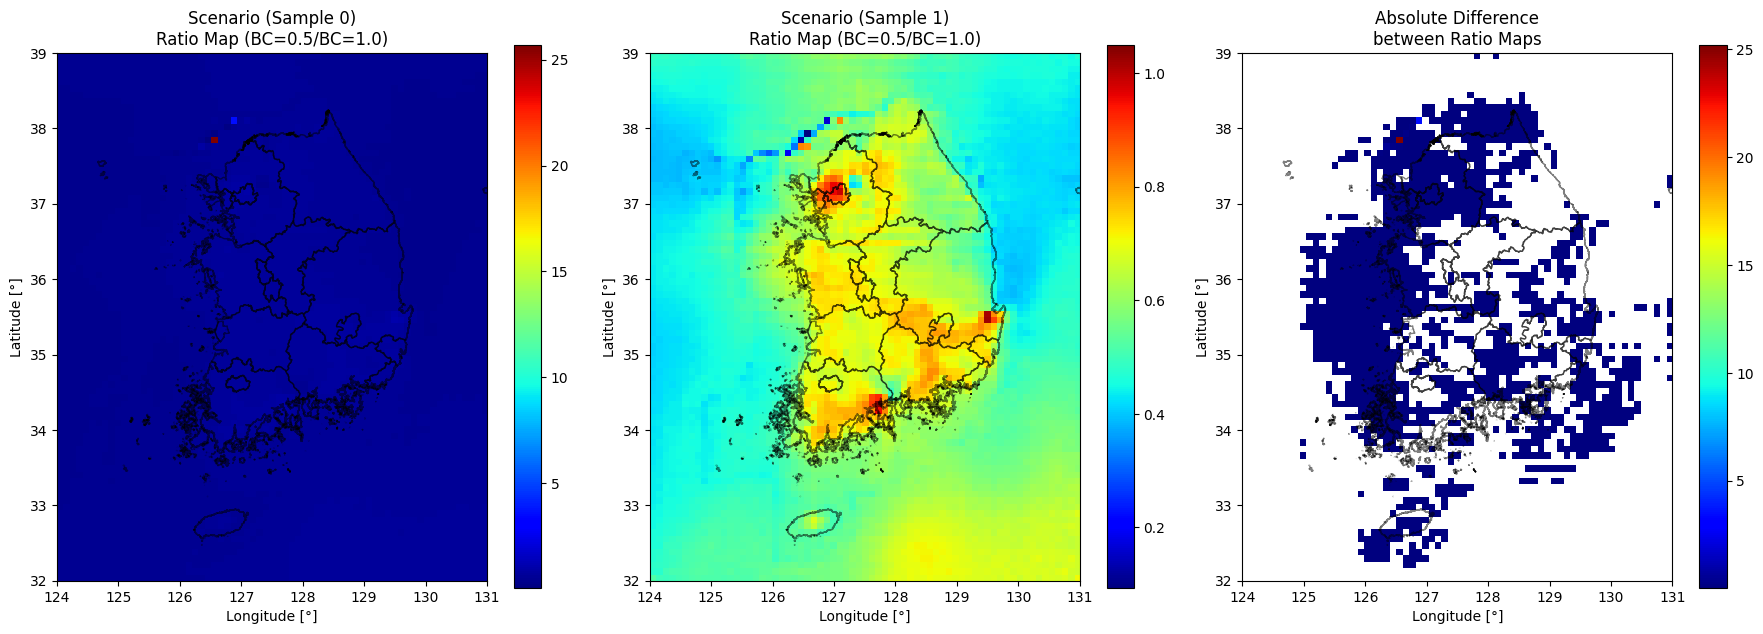

1/1 [==============================] - 0s 65ms/step


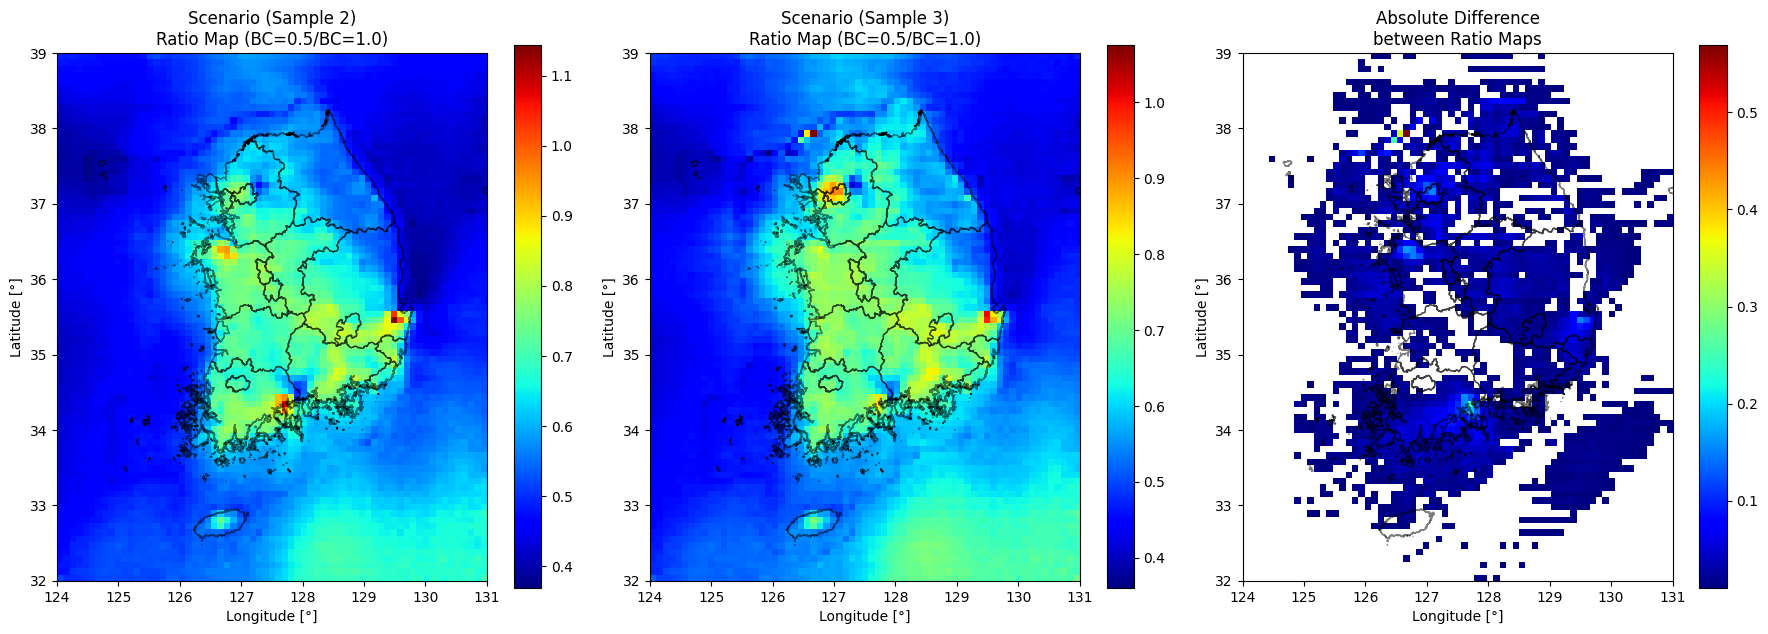

1/1 [==============================] - 0s 61ms/step


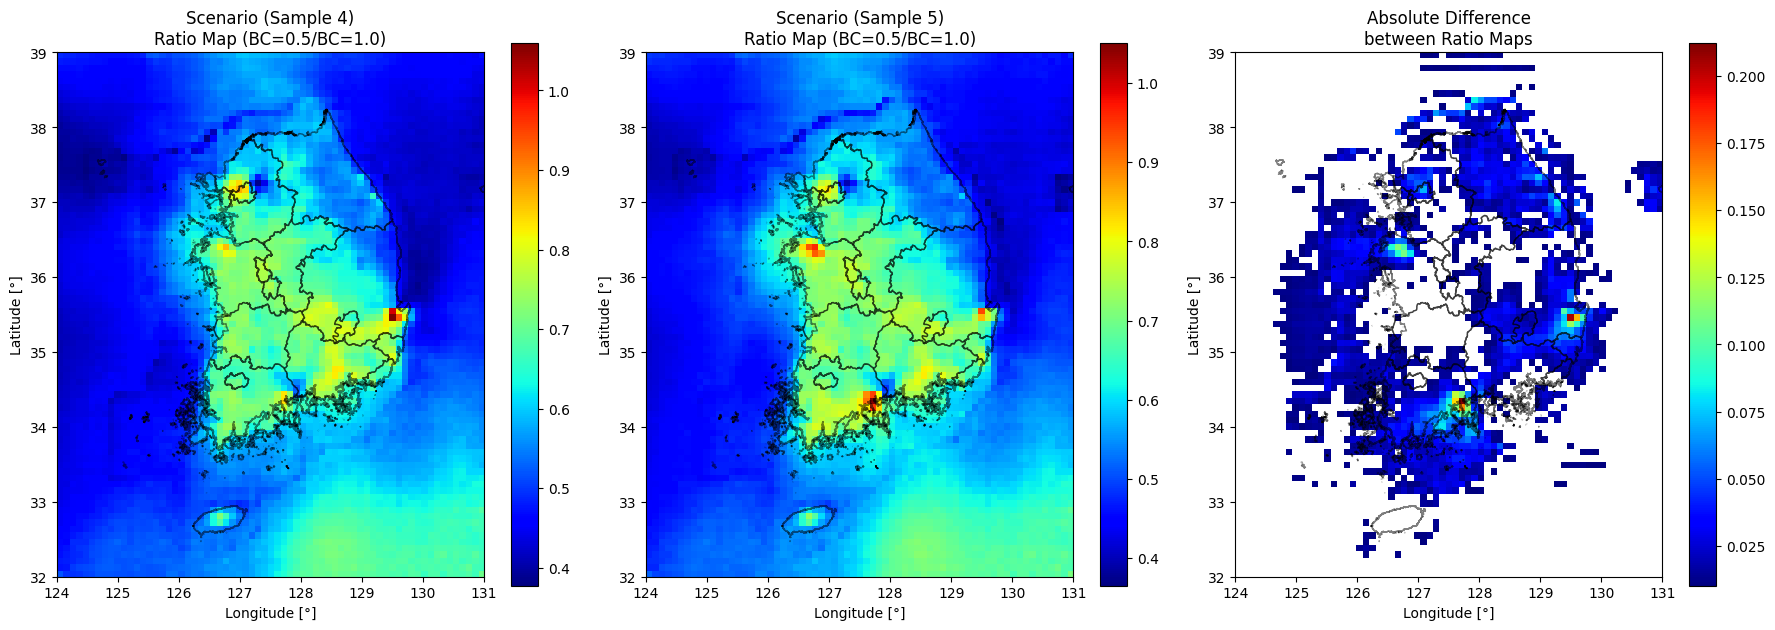

1/1 [==============================] - 0s 62ms/step


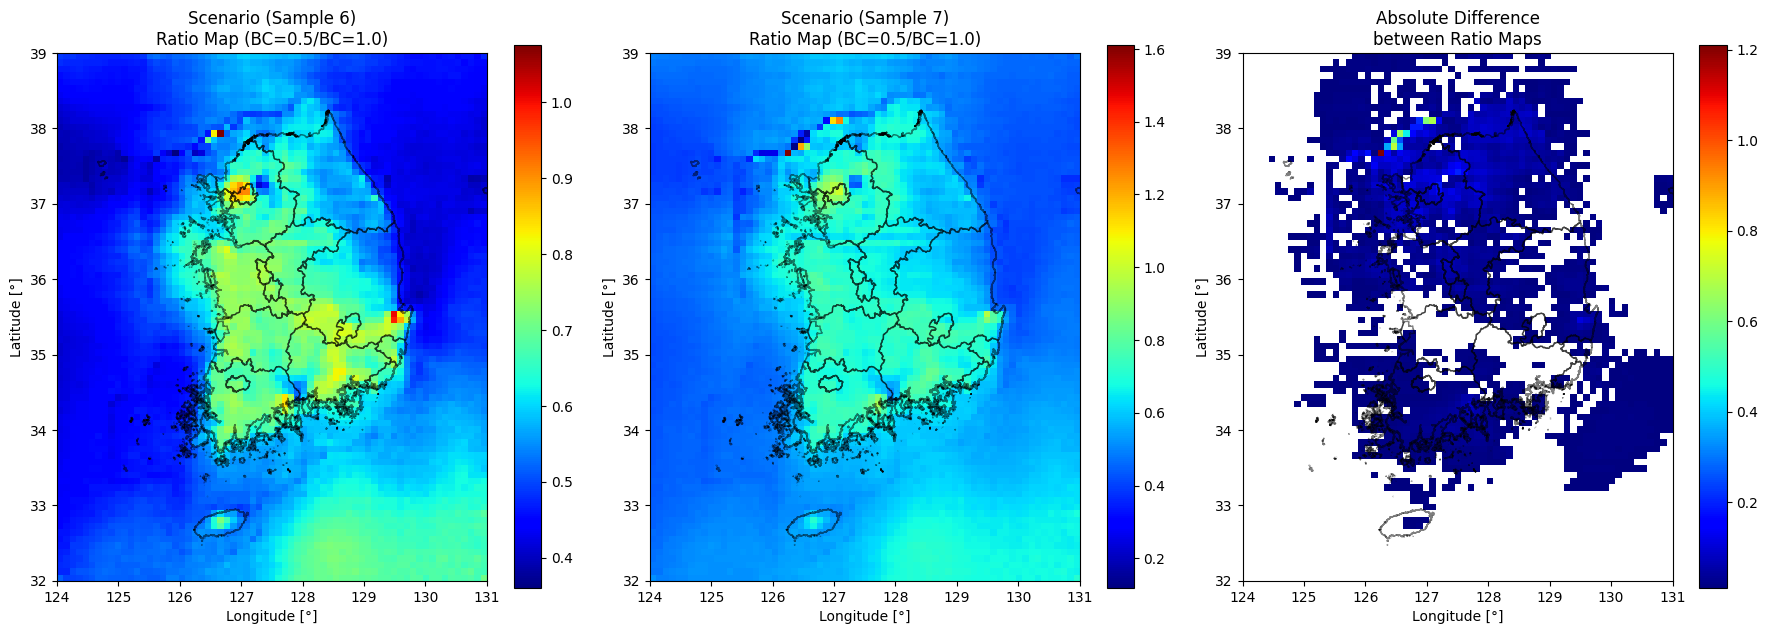

1/1 [==============================] - 0s 61ms/step


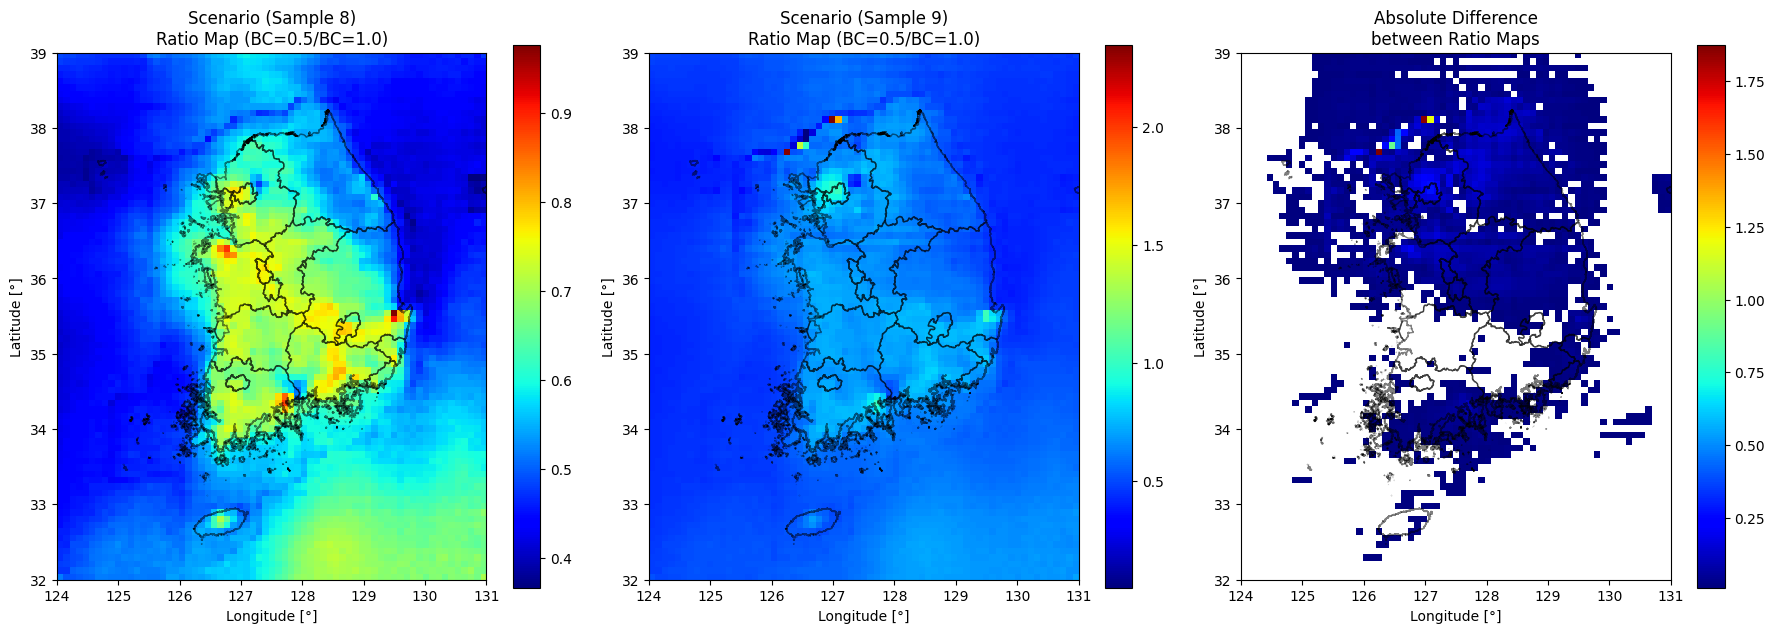

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# --- 1. 함수 정의 --- #
def get_prediction_for_boundary(model, control_input, boundary_value):
    """
    model: 학습된 모델 (두 입력을 받음, [control, condition])
    control_input: 1차원 벡터, shape=(ctrl_dim,)
    boundary_value: scalar, 예: 0.5 또는 1.0
    Returns:
        pred_map: 예측 결과, shape=(82,67,1)
    """
    boundary_input = np.array([boundary_value], dtype=np.float32)  # shape (1,)
    control_batch = np.expand_dims(control_input, axis=0)            # (1, ctrl_dim)
    boundary_batch = np.expand_dims(boundary_input, axis=0)            # (1, 1)
    pred = model.predict([control_batch, boundary_batch])
    return pred[0]

def compute_ratio_map(pred_map_low, pred_map_high):
    """
    두 예측 맵을 elementwise로 나눠서 ratio map을 구함.
    pred_map_low, pred_map_high: shape (82,67,1)
    Returns:
        ratio_map: shape (82,67) (채널 축 제거)
    """
    ratio_map = pred_map_low / pred_map_high
    return np.squeeze(ratio_map, axis=-1)

def plot_ratio_maps_subplot(ratio_map1, ratio_map2, ratio_diff, sample_idx1, sample_idx2):
    """
    1행 3열의 subplot에
    - 좌측: 첫 번째 시나리오의 ratio map,
    - 중앙: 두 번째 시나리오의 ratio map,
    - 우측: 두 ratio map의 절대 차이
    를 표시함.
    """
    threshold = 0.01
    x_min = -180000 + offset_x
    x_max =  414000 + offset_x
    y_min = -585000 + offset_y
    y_max =  144000 + offset_y

    x_ticks = np.linspace(x_min, x_max, 8)
    x_labels = [str(i) for i in range(124, 132)]
    y_ticks = np.linspace(y_min, y_max, 8)
    y_labels = [str(i) for i in range(32, 40)]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    map1 = ratio_map1[::-1]
    masked_map1 = np.ma.masked_where(map1 <= threshold, map1)
    # 실제 지도 좌표계 (예: x_min, x_max, y_min, y_max) 지정
    im0 = axs[0].imshow(
        masked_map1,
        cmap="jet",
        origin='upper',  # 또는 'lower'
        extent=(x_min, x_max, y_min, y_max)
    )
    ctprvn_proj.boundary.plot(ax=axs[0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.5)
    axs[0].set_title(f"Scenario (Sample {sample_idx1})\nRatio Map (BC=0.5/BC=1.0)")
    axs[0].set_xlabel('Longitude [°]')
    axs[0].set_ylabel('Latitude [°]')
    axs[0].set_xlim(x_min, x_max)
    axs[0].set_ylim(y_min, y_max)
    axs[0].set_xticks(x_ticks)
    axs[0].set_yticks(y_ticks)
    axs[0].set_xticklabels(x_labels)
    axs[0].set_yticklabels(y_labels)
    plt.colorbar(im0, ax=axs[0])
    
    map2 = ratio_map2[::-1]
    masked_map2 = np.ma.masked_where(map2 <= threshold, map2)
    im1 = axs[1].imshow(
        masked_map2,
        cmap="jet",
        origin='upper',  # 또는 'lower'
        extent=(x_min, x_max, y_min, y_max)
    )
    ctprvn_proj.boundary.plot(ax=axs[1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.5)
    axs[1].set_title(f"Scenario (Sample {sample_idx2})\nRatio Map (BC=0.5/BC=1.0)")
    axs[1].set_xlabel('Longitude [°]')
    axs[1].set_ylabel('Latitude [°]')
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    axs[1].set_xticks(x_ticks)
    axs[1].set_yticks(y_ticks)
    axs[1].set_xticklabels(x_labels)
    axs[1].set_yticklabels(y_labels)
    plt.colorbar(im1, ax=axs[1])
    
    map3 = ratio_diff[::-1]
    masked_map3 = np.ma.masked_where(map3 <= threshold, map3)
    im2 = axs[2].imshow(
        masked_map3,
        cmap="jet",
        origin='upper',  # 또는 'lower'
        extent=(x_min, x_max, y_min, y_max)
    )
    ctprvn_proj.boundary.plot(ax=axs[2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.5)
    axs[2].set_title("Absolute Difference\nbetween Ratio Maps")
    axs[2].set_xlabel('Longitude [°]')
    axs[2].set_ylabel('Latitude [°]')
    axs[2].set_xlim(x_min, x_max)
    axs[2].set_ylim(y_min, y_max)
    axs[2].set_xticks(x_ticks)
    axs[2].set_yticks(y_ticks)
    axs[2].set_xticklabels(x_labels)
    axs[2].set_yticklabels(y_labels)
    plt.colorbar(im2, ax=axs[2])
    
    plt.tight_layout()
    plt.show()

def multi_scenario_ratio_analysis(model, control_inputs, sample_indices):
    """
    model: 학습된 모델 (두 입력을 받음)
    control_inputs: 전체 control input 데이터 (배열, shape=(n_samples, ctrl_dim))
    sample_indices: 각 iteration에서 사용할 샘플 인덱스들의 리스트.
                    (예: [0,1,2,3,...] 짝수 개여야 함)
    각 iteration마다 sample_indices에서 2개씩 묶어, 두 시나리오에 대해
    BC=0.5와 BC=1.0에서의 예측 결과로부터 ratio map과 그 차이를 계산 및 시각화함.
    """
    # 인덱스 개수가 짝수가 아니면 마지막 인덱스는 무시
    if len(sample_indices) % 2 != 0:
        sample_indices = sample_indices[:-1]
    num_iters = len(sample_indices) // 2
    for i in range(num_iters):
        idx1 = sample_indices[2 * i]
        idx2 = sample_indices[2 * i + 1]
        
        # 첫 번째 시나리오
        base_control1 = control_inputs[idx1]
        pred_map1_low = get_prediction_for_boundary(model, base_control1, boundary_value=0.5)
        pred_map1_high = get_prediction_for_boundary(model, base_control1, boundary_value=1.0)
        ratio_map1 = compute_ratio_map(pred_map1_low, pred_map1_high)
        
        # 두 번째 시나리오
        base_control2 = control_inputs[idx2]
        pred_map2_low = get_prediction_for_boundary(model, base_control2, boundary_value=0.5)
        pred_map2_high = get_prediction_for_boundary(model, base_control2, boundary_value=1.0)
        ratio_map2 = compute_ratio_map(pred_map2_low, pred_map2_high)
        
        # 두 시나리오의 ratio map 차이
        ratio_diff = np.abs(ratio_map1 - ratio_map2)
        
        # Subplot으로 시각화
        plot_ratio_maps_subplot(ratio_map1, ratio_map2, ratio_diff, idx1, idx2)

# --- 2. 사용 예 --- #
# 가정: X_emis_test는 전체 control input 데이터, shape=(n_samples, ctrl_dim)
# 모델은 이미 로드되어 있음.
# 예를 들어, 10개의 샘플 중 0부터 9까지를 중복 없이 사용:
sample_indices = np.arange(10)  # 예: 10개의 샘플 사용 (5 iteration)
multi_scenario_ratio_analysis(model, X_emis_test, sample_indices)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
from numpy.random import RandomState
from scipy import stats

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU 메모리 성장 활성화 완료")
    except RuntimeError as e:
        print(e)

def get_prediction_for_boundary(model, control_input, boundary_value):
    """시나리오에 대한 예측 수행"""
    boundary_input = np.array([boundary_value], dtype=np.float32)
    control_batch = np.expand_dims(control_input, axis=0)
    boundary_batch = np.expand_dims(boundary_input, axis=0)
    pred = model.predict([control_batch, boundary_batch], verbose=0)
    return pred[0]  # (82,67,1)

def compute_ratio_map(pred_map_low, pred_map_high):
    """ratio map 계산"""
    ratio_map = pred_map_low / pred_map_high
    return np.squeeze(ratio_map, axis=-1)  # (82,67)

# 모델 로드
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/final_model_v2')

# 입력 데이터셋 로드
emis_ctrl_2019 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_pm25.csv')

# 기준 시나리오 선택 (모든 값이 1인 행 찾기)
reference_scenario = emis_ctrl_2019.iloc[(emis_ctrl_2019.iloc[:, :17*4] == 1).all(axis=1).idxmax()]
reference_input = reference_scenario.values[:17*4]

# 기준 시나리오의 ratio map 계산
ref_pred_05 = get_prediction_for_boundary(model, reference_input, 0.5)
ref_pred_10 = get_prediction_for_boundary(model, reference_input, 1.0)
ref_ratio_map = compute_ratio_map(ref_pred_05, ref_pred_10)
ref_ratio_values = ref_ratio_map.flatten()  # 1차원으로 변환

# 랜덤하게 n개의 비교 시나리오 선택
n_scenarios = 6  # 비교할 시나리오 개수
random_seed = 42
random_state = RandomState(random_seed)
total_scenarios = len(emis_ctrl_2019)
selected_indices = random_state.choice(total_scenarios, size=n_scenarios, replace=False)
# select_idx = [0, 30, 60, 90, 118]
selected_emis_ctrl = emis_ctrl_2019.iloc[selected_indices]

print(f"\n선택된 시나리오 인덱스: {selected_indices}")
print(f"데이터 포인트 수: {len(ref_ratio_values)}")  # 82*67 확인

# 각 시나리오별 ratio map 계산 및 scatter plot 생성
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# 마스킹 처리를 위한 grid allocation 데이터 로드
grid_alloc = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv')
grid_alloc = grid_alloc.sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False])
grid_alloc = grid_alloc.drop_duplicates(subset=['Row', 'Column'], keep='first')
grid_alloc = grid_alloc.reset_index(drop=True)

# 마스크 생성
mask = np.zeros((82, 67))
row_indices = grid_alloc['Row'].values - 1  # 0-based indexing으로 변환
col_indices = grid_alloc['Column'].values - 1
mask[row_indices, col_indices] = 1

def compute_masked_ratio_values(ratio_map, mask):
    """마스킹된 영역의 ratio 값만 추출"""
    masked_ratio = ratio_map[mask == 1]
    return masked_ratio

# Scatter plot 생성 부분 수정
for idx, (scenario_idx, row) in enumerate(selected_emis_ctrl.iterrows()):
    scenario_input = row.values[:17*4]
    pred_05 = get_prediction_for_boundary(model, scenario_input, 0.5)
    pred_10 = get_prediction_for_boundary(model, scenario_input, 1.0)
    scenario_ratio_map = compute_ratio_map(pred_05, pred_10)
    scenario_ratio_values = scenario_ratio_map.flatten()
    # 마스킹된 영역의 값만 추출
    ref_masked_values = compute_masked_ratio_values(ref_ratio_map, mask)
    scenario_masked_values = compute_masked_ratio_values(scenario_ratio_map, mask)
    
    # Scatter plot 생성
    ax = axes[idx]
    hist = ax.hist2d(ref_masked_values, scenario_masked_values,
                    bins=100, cmap='jet', cmin=1,
                    norm=mpl.colors.LogNorm(vmin=1, vmax=1000))
    
    # 상관계수 계산 (마스킹된 영역만)
    correlation = stats.pearsonr(ref_masked_values, scenario_masked_values)[0]
    
    # 대각선 그리기
    min_val = min(ref_ratio_values.min(), scenario_ratio_values.min())
    max_val = max(ref_ratio_values.max(), scenario_ratio_values.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    
    ax.set_xlabel('Reference Scenario Ratio')
    ax.set_ylabel(f'Scenario {scenario_idx} Ratio')
    ax.set_title(f'Correlation: {correlation:.3f}')
    ax.grid(True, alpha=0.3)
    
    # 각 subplot에 컬러바 추가
    cbaxes = ax.inset_axes([0.6, 0.1, 0.35, 0.03])
    cb = plt.colorbar(hist[3], cax=cbaxes, orientation='horizontal')
    cb.set_label('Number of samples', fontsize=8)
    cb.ax.tick_params(labelsize=6)

# 사용하지 않는 subplot 제거
for idx in range(n_scenarios, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('ratio_comparison_scatter.png', dpi=300, bbox_inches='tight')
plt.close()

# 상관계수 출력
print("\n=== 기준 시나리오와의 상관계수 ===")
for idx, (scenario_idx, row) in enumerate(selected_emis_ctrl.iterrows()):
    scenario_input = row.values[:17*4]
    pred_05 = get_prediction_for_boundary(model, scenario_input, 0.5)
    pred_10 = get_prediction_for_boundary(model, scenario_input, 1.0)
    scenario_ratio_map = compute_ratio_map(pred_05, pred_10)
    correlation = stats.pearsonr(ref_ratio_map.flatten(), scenario_ratio_map.flatten())[0]
    print(f"시나리오 {scenario_idx}: {correlation:.4f}")

GPU 메모리 성장 활성화 완료
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')



선택된 시나리오 인덱스: [ 56  89   4  45  26 117]
데이터 포인트 수: 5494

=== 기준 시나리오와의 상관계수 ===
시나리오 56: 0.9787
시나리오 89: 0.9574
시나리오 4: 0.9944
시나리오 45: 0.9838
시나리오 26: 0.9915
시나리오 117: 0.7817


2025-03-20, 학회 nitrate 결과의 경우, 데이터셋에 o3 추가 유/무에 따른 결과 비교를 강조


선택된 시나리오 인덱스: [1, 68, 79, 83, 32]


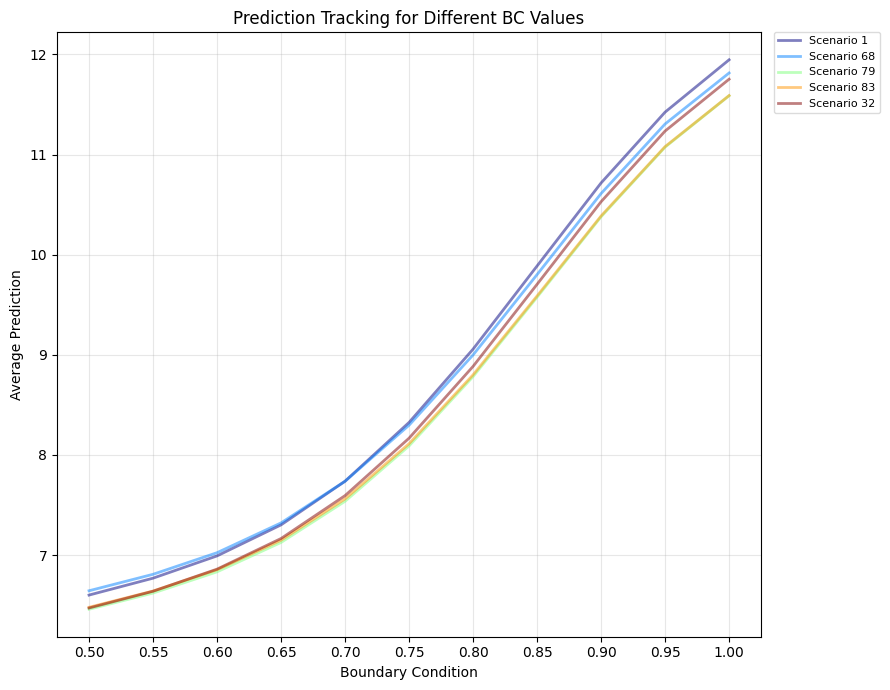

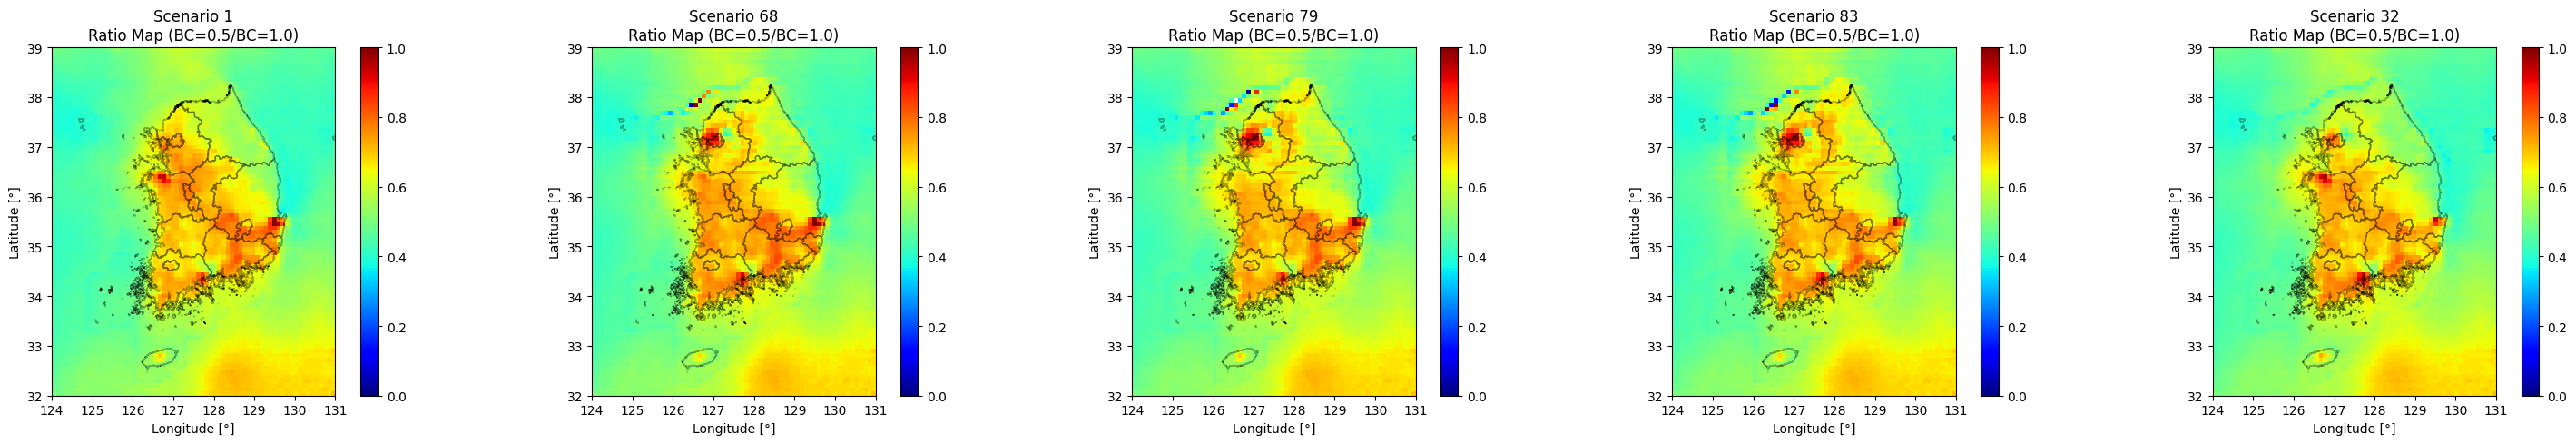

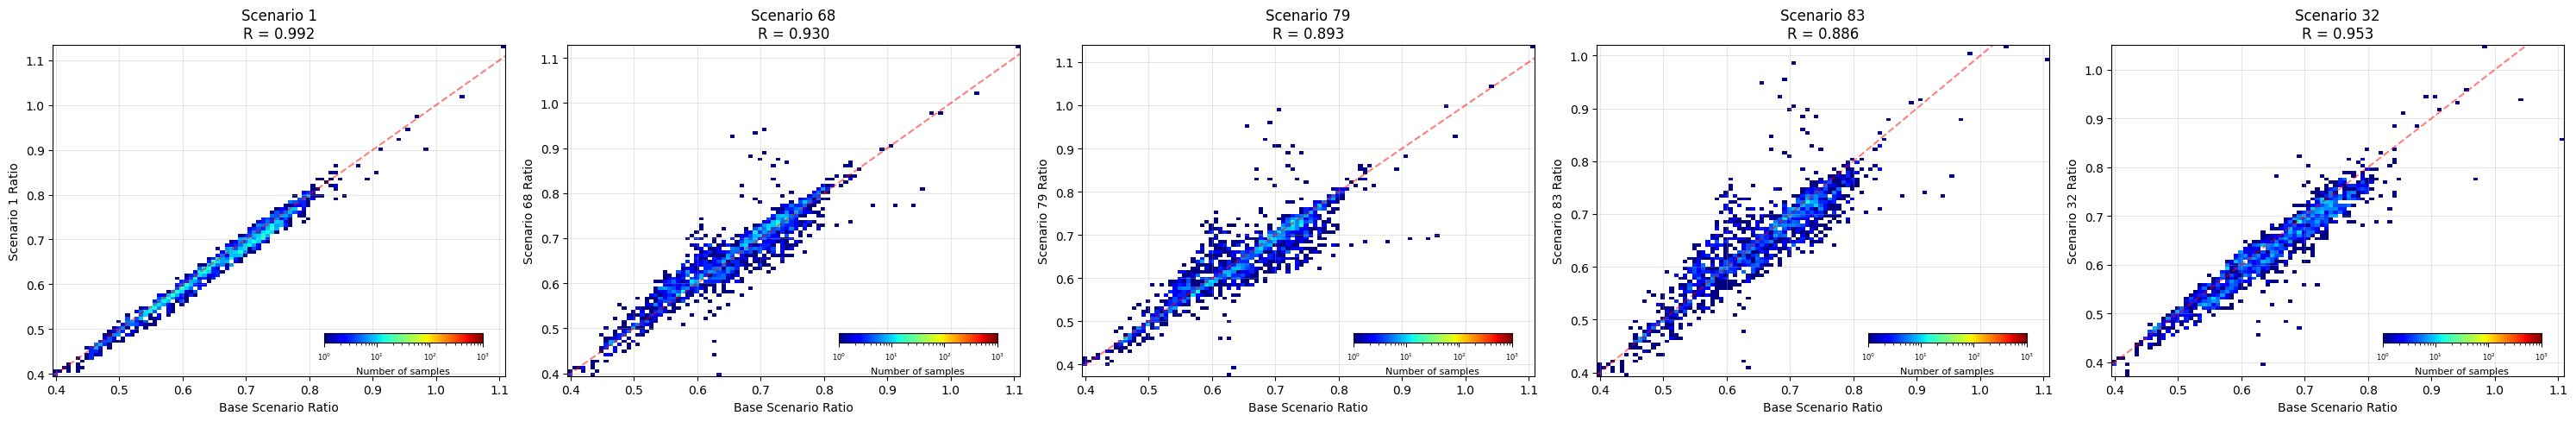

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.gridspec import GridSpec
import random

# GPU 메모리 성장 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 1. 모델 및 데이터 로드
def load_model_and_data():
    # 모델 로드
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/final_model_v2')
    
    # 격자 할당 데이터 로드
    grid_alloc = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv')
    
    # 입력 데이터셋 로드
    emis_ctrl = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_pm25.csv')
    
    # 마스크 생성
    grid_alloc = grid_alloc.sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False])
    grid_alloc = grid_alloc.drop_duplicates(subset=['Row', 'Column'], keep='first')
    mask = np.zeros((82, 67))
    mask[grid_alloc['Row'].values - 1, grid_alloc['Column'].values - 1] = 1
    
    return model, mask, emis_ctrl

# 2. 유틸리티 함수들
def get_prediction_for_boundary(model, emis_control, boundary_value):
    """단일 시나리오에 대한 예측"""
    control_batch = np.expand_dims(emis_control, axis=0)            # (1, ctrl_dim)
    boundary_batch = np.expand_dims(np.array([boundary_value], dtype=np.float32), axis=0)  # (1, 1)
    pred = model.predict([control_batch, boundary_batch], verbose=0)
    return pred[0]

def compute_ratio_map(pred_map_low, pred_map_high, epsilon=1e-10):
    """Ratio map 계산"""
    return np.squeeze(pred_map_low / (pred_map_high + epsilon))

def apply_mask(data, mask):
    """마스크 적용하여 한국 영토 영역만 추출"""
    return data[mask == 1]

# 3. 시각화 함수들
def plot_bc_tracking(model, scenarios, scenario_indices, bc_values):
    """BC 값 변화에 따른 평균 예측값 추적"""
    plt.figure(figsize=(9, 7))
    colors = plt.cm.jet(np.linspace(0, 1, len(scenarios)))
    
    for (scenario, idx), color in zip(zip(scenarios, scenario_indices), colors):
        predictions = []
        for bc in bc_values:
            pred = get_prediction_for_boundary(model, scenario, bc)
            predictions.append(np.mean(pred))
            
        # 점들을 연결하는 선
        plt.plot(bc_values, predictions, '-', color=color, alpha=0.5, linewidth=2,
                label=f'Scenario {idx}')
    
    plt.xlabel('Boundary Condition')
    plt.ylabel('Average Prediction')
    plt.title('Prediction Tracking for Different BC Values')
    plt.grid(True, alpha=0.3)
    
    # x축 눈금 설정 (0.5부터 1.0까지 0.05 간격)
    plt.xticks(np.arange(0.5, 1.05, 0.05))
    
    # 범례를 그래프 내부 우상단에 표시
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.01),
              ncol=1, fontsize=8, framealpha=0.7)
    
    plt.tight_layout()
    plt.show()

def plot_ratio_maps(model, scenarios, scenario_indices, mask):
    """선택된 시나리오들의 Ratio Map"""
    n_scenarios = len(scenarios)
    fig, axes = plt.subplots(1, n_scenarios, figsize=(6*n_scenarios, 5))
    if n_scenarios == 1:
        axes = [axes]
        
    # 좌표계 설정
    threshold = 0.01
    x_min = -180000 + offset_x
    x_max = 414000 + offset_x
    y_min = -585000 + offset_y
    y_max = 144000 + offset_y

    x_ticks = np.linspace(x_min, x_max, 8)
    x_labels = [str(i) for i in range(124, 132)]
    y_ticks = np.linspace(y_min, y_max, 8)
    y_labels = [str(i) for i in range(32, 40)]
    
    for idx, (ax, scenario, scenario_idx) in enumerate(zip(axes, scenarios, scenario_indices)):
        # Ratio map 계산
        pred_0_5 = get_prediction_for_boundary(model, scenario, 0.5)
        pred_1_0 = get_prediction_for_boundary(model, scenario, 1.0)
        ratio_map = compute_ratio_map(pred_0_5, pred_1_0)
        
        # 마스킹 처리
        map_data = ratio_map[::-1]  # 상하 반전
        masked_map = np.ma.masked_where(map_data <= threshold, map_data)
        
        # 지도 표시
        im = ax.imshow(
            masked_map,
            cmap="jet",
            origin='upper',
            extent=(x_min, x_max, y_min, y_max),
            vmin=0, vmax=1
        )
        
        # 행정구역 경계 표시
        ctprvn_proj.boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1, alpha=0.3)
        
        # 축 설정
        ax.set_title(f"Scenario {scenario_idx}\nRatio Map (BC=0.5/BC=1.0)")
        ax.set_xlabel('Longitude [°]')
        ax.set_ylabel('Latitude [°]')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_yticklabels(y_labels)
        
        # 컬러바 추가
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

def plot_scatter_comparison(model, base_scenario, scenarios, scenario_indices, mask):
    """기준 시나리오와 선택된 시나리오들의 Ratio Map Scatter Plot"""
    n_scenarios = len(scenarios)
    fig, axes = plt.subplots(1, n_scenarios, figsize=(6*n_scenarios, 5))
    if n_scenarios == 1:
        axes = [axes]
    
    # 기준 시나리오의 ratio map
    base_0_5 = get_prediction_for_boundary(model, base_scenario, 0.5)
    base_1_0 = get_prediction_for_boundary(model, base_scenario, 1.0)
    base_ratio = compute_ratio_map(base_0_5, base_1_0)
    base_masked = apply_mask(base_ratio, mask)
    
    for idx, (ax, scenario, scenario_idx) in enumerate(zip(axes, scenarios, scenario_indices)):
        pred_0_5 = get_prediction_for_boundary(model, scenario, 0.5)
        pred_1_0 = get_prediction_for_boundary(model, scenario, 1.0)
        ratio_map = compute_ratio_map(pred_0_5, pred_1_0)
        scenario_masked = apply_mask(ratio_map, mask)
        
        # Scatter plot with hist2d
        hist = ax.hist2d(base_masked, scenario_masked,
                        bins=100, cmap='jet', cmin=1,
                        norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        
        # 상관계수 계산
        corr = stats.pearsonr(base_masked, scenario_masked)[0]
        
        # 대각선 그리기
        min_val = min(base_masked.min(), scenario_masked.min())
        max_val = max(base_masked.max(), scenario_masked.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
        
        ax.set_title(f'Scenario {scenario_idx}\nR = {corr:.3f}')
        ax.set_xlabel('Base Scenario Ratio')
        ax.set_ylabel(f'Scenario {scenario_idx} Ratio')
        ax.grid(True, alpha=0.3)
        
        # 각 subplot에 컬러바 추가
        cbaxes = ax.inset_axes([0.6, 0.1, 0.35, 0.03])
        cb = plt.colorbar(hist[3], cax=cbaxes, orientation='horizontal')
        cb.set_label('Number of samples', fontsize=8)
        cb.ax.tick_params(labelsize=6)
    
    plt.tight_layout()
    plt.show()

# 4. 메인 실행 코드
def main():
    # 모델 및 데이터 로드
    model, mask, emis_ctrl = load_model_and_data()
    
    # 시나리오 선택
    n_scenarios = 5
    total_scenarios = len(emis_ctrl)
    selected_indices = random.sample(range(total_scenarios), n_scenarios)
    
    print(f"\n선택된 시나리오 인덱스: {selected_indices}")
    
    # 선택된 시나리오의 데이터 추출
    selected_scenarios = [emis_ctrl.iloc[idx].values[:-1] for idx in selected_indices]  # 마지막 열(Boundary) 제외
    base_scenario = emis_ctrl.iloc[0].values[:-1]  # 첫 번째 행을 base scenario로 사용 (마지막 열 제외)
    
    # BC 값 범위 설정
    bc_values = np.arange(0.5, 1.05, 0.05)
    
    # 1. BC tracking plot
    plot_bc_tracking(model, selected_scenarios, selected_indices, bc_values)
    
    # 2. Ratio maps
    plot_ratio_maps(model, selected_scenarios, selected_indices, mask)
    
    # 3. Scatter plots
    plot_scatter_comparison(model, base_scenario, selected_scenarios, selected_indices, mask)

if __name__ == "__main__":
    main()